In [15]:
import numpy as np
import matplotlib.pyplot as plt
import aipy as a 
import capo
import capo.miriad as miriad
from scipy.sparse import csr_matrix
from tqdm import tqdm
import capo.omni as omni
from copy import deepcopy
import seaborn
%matplotlib notebook 

# Array Classes

In [2]:
class InterferometricArray():
    """Class that takes a list of positions and can calcuate baselines and redundancies."""
    
    def __init__(self, positions=[]):
        self.positions = np.array(positions)
        self.nant = len(positions)
        self.antNames = range(self.nant)
    
    def CalculateUBLs(self, precisionFactor=1000000):
        """Finds the baselines, unique baselines, and related dictionaries for indexing."""
        self.blVectors, self.blNamePairs, self.blIndexPairs = [], [], []
        self.index2name = {i:name for i,name in enumerate(self.antNames)}
        self.name2index = {name:i for i,name in enumerate(self.antNames)}
        self.name2pos = {name: self.positions[self.name2index[name]] for name in self.antNames}
        for index1,ant1 in enumerate(self.antNames):
            for index2,ant2 in zip(range(index1+1,self.nant), self.antNames[index1+1:]):
                delta = np.array([int(np.round(precisionFactor*(self.positions[index1][i] - self.positions[index2][i]))) for i in range(3)])
                if delta[1] > 0 or (delta[1] == 0 and delta[0] > 0): 
                    self.blVectors.append(tuple(delta))
                    self.blNamePairs.append((ant1, ant2))
                    self.blIndexPairs.append((index1, index2))
                else: 
                    self.blVectors.append(tuple(-delta))
                    self.blNamePairs.append((ant2, ant1))
                    self.blIndexPairs.append((index2, index1))
        self.ublDict = {}
        for b in range(len(self.blVectors)):
            if self.ublDict.has_key(self.blVectors[b]): self.ublDict[self.blVectors[b]].append(self.blNamePairs[b])
            else: self.ublDict[self.blVectors[b]] = [self.blNamePairs[b]]
        self.blIndexDict = {antPair: i for i,antPair in enumerate(self.blNamePairs)}
        self.names2ublIndex = {antPair: i for i,antPairs in enumerate(self.ublDict.values()) for antPair in antPairs}
        self.indices2ublIndex = {(self.name2index[antPair[0]],self.name2index[antPair[1]]): 
                                 i for i,antPairs in enumerate(self.ublDict.values()) for antPair in antPairs}
        self.ublVectors = np.array([self.name2pos[antList[0][0]]-self.name2pos[antList[0][1]] for antList in self.ublDict.values()])
        self.ublGroups = [antList for antList in self.ublDict.values()]
        print "With", len(self.positions), "antennas there are", len(self.ublDict.items()), "unique baselines."
        self.nbl, self.nubl = len(self.blNamePairs), len(self.ublVectors)

class HexagonalArray(InterferometricArray):
    """Generates a hexagonal array."""
    
    def __init__(self, separation, hexNum, verbose=False):
        """Creates a hexagonal array with hexNum antennas per side separated by separation."""
        self.hexNum, self.separation, self.verbose = hexNum, separation, verbose
        positions, self.rowIndices, i = [], [], 0        
        for row in range(hexNum-1,-(hexNum),-1):
            indices = []
            for col in range(2*hexNum-abs(row)-1):
                xPos = ((-(2*hexNum-abs(row))+2)/2.0 + col)*separation;
                yPos = row*separation*3**.5/2;
                positions.append([xPos, yPos, 0])
                indices.append(i); i+=1
            self.rowIndices.append(indices)
        self.positions = np.array(positions) 
        self.nant = len(self.positions)
        self.antNames = range(self.nant)

class InterferometricArrayFromAA(InterferometricArray):
    
    def __init__(self, aa, xants=[]):
        self.positions = np.array([pos for i,pos in enumerate(aa.antpos_ideal) if pos[2] != -1.0 and i not in xants])
        self.antNames = [i for i,pos in enumerate(aa.antpos_ideal) if pos[2] != -1.0 and i not in xants]
        self.nant = len(self.positions)
    

# Omnicalibrator Class


In [82]:
class OmniCalibrator():
    """This class contains method functions for the key steps in Omnical and stores relevant information about the array."""
    
    def __init__(self, array, verbose=True):
        self.a = array
        self.verbose = verbose
        antloc = np.array(self.a.positions); antloc[:,2] = 0
        R = np.array([np.append(ai,1) for ai in antloc]); #Get the R matrix. R = [r_i 1], where ri are the positions
        self.R2 = np.vstack((R, np.hstack((-self.a.ublVectors, np.zeros((self.a.nubl,1))))))
        self.M2 = np.linalg.pinv(self.R2.T.dot(self.R2)).dot(self.R2.T)
        return
    
    def ComputeErrors(self, obsVis, gainSols, visSols):
        """Computes the difference between the calibration model and the observation."""
        modelObs = np.array([gainSols[ant1] * np.conj(gainSols[ant2]) * visSols[self.a.indices2ublIndex[(ant1,ant2)]] 
                             for (ant1,ant2),obs in zip(self.a.blIndexPairs,obsVis)])
        return obsVis - modelObs

    def PerChannelDegeneracyCorrection(self, gainSols, visSols, degenGains, degenVis):
        """This function fixes the gain and phase degeneracies on a per-channel basis. Vulnerable to phase wrapping and related problems."""
        newGainSols, newVisSols = gainSols.copy(), visSols.copy()

        #Fix amplitudes
        newGainSols = gainSols * np.exp(1.0j * (np.mean(np.angle(degenGains)) - np.mean(np.angle(newGainSols))))
        newGainSols = gainSols / np.mean(np.abs(gainSols)) * np.mean(np.abs(degenGains))
        newVisSols = visSols * np.mean(np.abs(gainSols))**2 / np.mean(np.abs(degenGains))**2
        
        #Fix phases
        fullPhaseDegen = self.R2.dot(self.M2)
        fullPhaseProj = np.eye(self.a.nant + self.a.nubl) - fullPhaseDegen
        newPhases = fullPhaseProj.dot(np.angle(np.append(newGainSols, newVisSols))) + fullPhaseDegen.dot(np.angle(np.append(degenGains,degenVis)))
        newSols = np.abs(np.append(newGainSols, newVisSols)) * np.exp(1.0j * newPhases)
        newGainSols, newVisSols = newSols[0:self.a.nant], newSols[self.a.nant:]
        return newGainSols, newVisSols
    
    def PerformLogcal(self, obsVis, degenGains, degenVis):
        """Performs logcal using obsVis and self.a. Degeneracies are fixed by using degenGains, degenVis."""
        Acoeffs, Bcoeffs, rowIndices, colIndices = [np.zeros(self.a.nbl*3) for i in range(4)]
        for n,(ant1,ant2) in enumerate(self.a.blIndexPairs):
            rowIndices[3*n:3*n+3] = n
            colIndices[3*n:3*n+3] = [ant1, ant2, self.a.nant + self.a.indices2ublIndex[(ant1,ant2)]]
            Acoeffs[3*n:3*n+3] = [1.0, 1.0, 1.0]
            Bcoeffs[3*n:3*n+3] = [1.0, -1.0, 1.0]

        logcalA = csr_matrix((Acoeffs,(rowIndices,colIndices)), shape=(self.a.nbl, self.a.nant + self.a.nubl))
        logcalB = csr_matrix((Bcoeffs,(rowIndices,colIndices)), shape=(self.a.nbl, self.a.nant + self.a.nubl))
        AtA = (logcalA.conj().T.dot(logcalA)).toarray()
        BtB = (logcalB.conj().T.dot(logcalB)).toarray()
        nZeroEigenvalues = [np.sum(np.abs(np.linalg.eigvals(XtX)<1e-10)) for XtX in [AtA, BtB]]
        if not nZeroEigenvalues == [1,3]: print 'WARNING: Array is not omnical-able.' 

        xReal = (np.linalg.pinv(AtA)).dot(logcalA.conj().T.dot(np.real(np.log(obsVis))))
        xImag = (np.linalg.pinv(BtB)).dot(logcalB.conj().T.dot(np.imag(np.log(obsVis))))
        xHat = np.exp(xReal + 1.0j*xImag)
        logcalGainSols, logcalVisSols = xHat[0:self.a.nant], xHat[self.a.nant:]        
        return self.PerChannelDegeneracyCorrection(logcalGainSols, logcalVisSols, degenGains, degenVis)
    
    def LincalAMatrix(self, gainSols, visSols, realImagMode=False):
        """Calculates A used for lincal as a compressed sparse row matrix."""
        Acoeffs, rowIndices, colIndices = [np.zeros(self.a.nbl*12) for i in range(3)]
        for n,(ant1,ant2) in enumerate(self.a.blIndexPairs):
            rowIndices[12*n:12*n+6] = 2*n
            rowIndices[12*n+6:12*n+12] = 2*n+1
            ublIndex = self.a.indices2ublIndex[(ant1,ant2)]
            colIndices[12*n:12*n+6] = [2*ant1, 2*ant1+1, 2*ant2, 2*ant2+1, 2*self.a.nant+2*ublIndex, 2*self.a.nant+2*ublIndex+1]
            colIndices[12*n+6:12*n+12] = [2*ant1, 2*ant1+1, 2*ant2, 2*ant2+1, 2*self.a.nant+2*ublIndex, 2*self.a.nant+2*ublIndex+1]
            if realImagMode: #Compute coefficients for Real/Imag version of lincal
                gi0V0 = gainSols[ant1] * visSols[ublIndex]
                gj0starV0 = np.conj(gainSols[ant2]) * visSols[ublIndex]
                gi0gj0star = gainSols[ant1] * np.conj(gainSols[ant2])
                Acoeffs[12*n:12*n+6] = [np.real(gj0starV0), -np.imag(gj0starV0), np.real(gi0V0), 
                                        np.imag(gi0V0), np.real(gi0gj0star), -np.imag(gi0gj0star)]
                Acoeffs[12*n+6:12*n+12] = [np.imag(gj0starV0), np.real(gj0starV0), np.imag(gi0V0), 
                                           -np.real(gi0V0), np.imag(gi0gj0star), np.real(gi0gj0star)]
            else: #Compute coefficients for Amp/Phase version of lincal
                gi0gj0star = gainSols[ant1] * np.conj(gainSols[ant2])
                gi0gj0starVij0 = gi0gj0star * visSols[ublIndex]
                Acoeffs[12*n:12*n+6] = [np.real(gi0gj0starVij0), -np.imag(gi0gj0starVij0), np.real(gi0gj0starVij0), 
                                        np.imag(gi0gj0starVij0), np.real(gi0gj0star), -np.imag(gi0gj0star)]
                Acoeffs[12*n+6:12*n+12] = [np.imag(gi0gj0starVij0), np.real(gi0gj0starVij0), np.imag(gi0gj0starVij0), 
                                           -np.real(gi0gj0starVij0), np.imag(gi0gj0star), np.real(gi0gj0star)]
        return csr_matrix((Acoeffs,(rowIndices,colIndices)), shape=(2*self.a.nbl, 2*self.a.nant + 2*self.a.nubl))
    
    def PerformLincal(self, obsVis, gainStart, visStart, degenGains, degenVis, realImagMode=False, maxIter=100, convCrit=1e-14, divCrit = 1e14):
        """Performs lincal, either in the amp/phase mode or the real/imag mode. Projects out degeneracies and replaces them."""
        gainSols, visSols = gainStart.copy(), visStart.copy()
        if self.verbose: print '\nNow performing Lincal using the', ('Amp/Phs','Re/Imag')[realImagMode], 'method...'
        startingChiSq = np.mean(np.abs(self.ComputeErrors(obsVis, gainSols, visSols))**2) #TODO: update with noise
        prevChiSq = startingChiSq
    
        for iteration in range(maxIter):            
            #Do all the linear algebra
            A = self.LincalAMatrix(gainSols, visSols, realImagMode=realImagMode)
            AtA = (A.conj().T.dot(A)).toarray()
            error = self.ComputeErrors(obsVis, gainSols, visSols)
            y = np.dstack((np.real(error),np.imag(error))).flatten()
            xHat = np.linalg.pinv(AtA).dot(A.conj().T.dot(y))
            
            #Update solutions
            updates = xHat[0::2] + 1.0j*xHat[1::2]
            if realImagMode: newGainSols = gainSols + updates[0:self.a.nant]
            else: newGainSols = gainSols * (1.0+updates[0:self.a.nant])
            newVisSols = visSols + updates[self.a.nant:]

            #Fix degeneracies if things have gone haywire
            chiSq = np.mean(np.abs(self.ComputeErrors(obsVis, newGainSols, newVisSols))**2)
            if chiSq > startingChiSq:
                newGainSols, newVisSols = self.PerChannelDegeneracyCorrection(newGainSols, newVisSols, degenGains, degenVis)
            #convergence = np.linalg.norm(np.append(newGainSols-gainSols,newVisSols-visSols)) / np.linalg.norm(np.append(newGainSols,newVisSols))
            convergence = np.abs(prevChiSq - chiSq) / chiSq
            if self.verbose: print iteration, ' -- chiSq =', chiSq, '    convCrit =', convergence
            
            #Check for convergence
            if chiSq/startingChiSq > divCrit or iteration == maxIter-1:
                print 'WARNING: Lincal in ' + ('Amp/Phs','Re/Imag')[realImagMode] + ' Mode did not converge in', iteration+1, 'iterations!'
                print '    Stopped at chiSq =', chiSq, '    convCrit =', convergence
                break
            if convergence < convCrit : 
                if self.verbose: print ('Amp/Phs','Re/Imag')[realImagMode] + ' Mode converged in', iteration+1, 'iterations.'
                if self.verbose: print '    Stopped at chiSq =', chiSq, '    convCrit =', convergence
                break
            gainSols, visSols, prevChiSq = newGainSols, newVisSols, chiSq
        
        return self.PerChannelDegeneracyCorrection(newGainSols, newVisSols, degenGains, degenVis)
    
    def OverallBandpassDegeneracyProjection(self, allGainSols, allVisSols, allGuessGains, allGuessVis):
        """This function corrects degeneracies, but only after unwrapping across all channels. """
        finalGainSols, finalVisSols, allDegenGains, allDegenVis = [np.array(this) for this in [allGainSols, allVisSols, allGuessGains, allGuessVis]]
        #overall phase unwrapping
        phaseShift = np.mean(np.unwrap(np.angle(finalGainSols).T).T,axis=1)
        for ant in range(self.a.nant): finalGainSols[:,ant] *= np.exp(-1.0j * phaseShift)

        #tip/tilt/phase unwrapping
        fullPhaseDegen = self.R2.dot(self.M2)
        fullPhaseProj = np.eye(self.a.nant + self.a.nubl) - fullPhaseDegen
        allDegens = []
        for chan in range(len(allGainSols)):
            unwrappedGainSols = np.array([np.unwrap(np.angle(finalGainSols[0:chan+1,ant]))[chan] for ant in range(self.a.nant)])
            unwrappedVisSols = np.array([np.unwrap(np.angle(finalVisSols[0:chan+1,ubl]))[chan] for ubl in range(self.a.nubl)])
            unwrappedDegenGains = np.array([np.unwrap(np.angle(np.array(allDegenGains)[0:chan+1,ant]))[chan] for ant in range(self.a.nant)])
            unwrappedDegenVis = np.array([np.unwrap(np.angle(np.array(allDegenVis)[0:chan+1,ubl]))[chan] for ubl in range(self.a.nubl)])
            
            newPhases = fullPhaseProj.dot(np.append(unwrappedGainSols, unwrappedVisSols))
            newPhases += fullPhaseDegen.dot(np.append(unwrappedDegenGains,unwrappedDegenVis))
            newSols = np.abs(np.append(finalGainSols[chan,:], finalVisSols[chan,:])) * np.exp(1.0j * newPhases)
            newGainSols, newVisSols = newSols[0:self.a.nant], newSols[self.a.nant:]
            finalGainSols[chan,:], finalVisSols[chan,:] = newGainSols, newVisSols
            
            #Figure out the degenerate part for everyone
            unwrappedGainSols = np.array([np.unwrap(np.angle(finalGainSols[0:chan+1,ant]))[chan] for ant in range(self.a.nant)])
            unwrappedVisSols = np.array([np.unwrap(np.angle(finalVisSols[0:chan+1,ubl]))[chan] for ubl in range(self.a.nubl)])
            allDegens.append(self.M2.dot(np.append(unwrappedGainSols, unwrappedVisSols)))

        #fix channel 0
        degeneratePart =  self.R2.dot(np.median(allDegens,axis=0))
        newPhases = fullPhaseProj.dot(np.append(np.angle(finalGainSols[0,:]), np.angle(finalVisSols[0,:])))
        newPhases += self.R2.dot(np.median(allDegens,axis=0))
        newSols = np.abs(np.append(finalGainSols[0,:], finalVisSols[0,:])) * np.exp(1.0j * newPhases)
        newGainSols, newVisSols = newSols[0:self.a.nant], newSols[self.a.nant:]
        finalGainSols[0,:], finalVisSols[0,:] = newGainSols, newVisSols
        return finalGainSols, finalVisSols
        

    def determineConjugationAndExemplars(self, data, v, pol='x'):
        """This function examines the data and guess visibility objects to build up relevant objects that say how the data is stored."""
        self.dataKeyConjugated = {}
        for (ant1,ant2) in self.a.blNamePairs:
            if data.has_key((ant1,ant2)): self.dataKeyConjugated[(ant1,ant2)] = False
            elif data.has_key((ant2,ant1)): self.dataKeyConjugated[(ant1,ant2)] = True
            else: raise KeyError('Cannot find baseline' + str((ant1,ant2)) + " in observed visibility data.")
        
        #Now examine the input visibility quantities
        self.visKey2ublIndex, self.visKeyConjugated = {}, {}
        self.ublIndex2VisKey = [None for i in range(self.a.nubl)]
        for n,ublGroup in enumerate(self.a.ublGroups):
            for (ant1,ant2) in ublGroup:
                if v[pol+pol].has_key((ant1,ant2)): 
                    self.visKey2ublIndex[(ant1,ant2)] = n
                    self.visKeyConjugated[(ant1,ant2)] = False
                    self.ublIndex2VisKey[n] = (ant1,ant2)
                elif v[pol+pol].has_key((ant2,ant1)): 
                    self.visKey2ublIndex[(ant2,ant1)] = n
                    self.visKeyConjugated[(ant2,ant1)] = True
                    self.ublIndex2VisKey[n] = (ant2,ant1)

    def pullOutSingleTime(self, time, data, g, v, pol='x', defaultVis=1.0):
        """This function pulls out observations, gains, and visibilities from the omnical data format. 
        If a particular unique baseline doesn't appear in v, defaultVis is used instead."""
        nint, nchan = data.values()[0].values()[0].shape
        allObsVis = np.ones((nchan, self.a.nbl), dtype=complex)
        allGains = np.ones((nchan, self.a.nant), dtype=complex)
        allVis = np.ones((nchan, self.a.nubl), dtype=complex)

        #Extract observed visbility data
        for n,(ant1,ant2) in enumerate(self.a.blNamePairs):
            if self.dataKeyConjugated[(ant1,ant2)]: allObsVis[:,n] =  np.conj(data[(ant2,ant1)][pol+pol][time])
            else: allObsVis[:,n] =  data[(ant1,ant2)][pol+pol][time]
        
        #Extract gains
        for n,ant in enumerate(self.a.antNames): allGains[:,n] = g[pol][ant][time]
        
        #Extract unique visibilities
        for n in range(self.a.nubl):
            visKey = self.ublIndex2VisKey[n]
            if visKey is None: allVis[:,n] *= defaultVis
            elif self.visKeyConjugated[visKey]: allVis[:,n] = np.conj(v[pol+pol][visKey][time])
            else: allVis[:,n] = v[pol+pol][visKey][time]

        return allObsVis, allGains, allVis
    
    def putBackSingleTime(self, time, chans, gSol, vSol, allGainSols, allVisSols, pol='x'):
        """For the single time slice and the specified channels, put gain/vis solutions into omnical format."""
        for n,ant in enumerate(self.a.antNames):
            gSol[pol][ant][time][chans] = allGainSols[:,n]

        for n in range(self.a.nubl):
            visKey = self.ublIndex2VisKey[n]
            if visKey is not None:
                if self.visKeyConjugated[visKey]: vSol[pol+pol][visKey][time][chans] = np.conj(allVisSols[:,n])
                else: vSol[pol+pol][visKey][time][chans] = allVisSols[:,n]
    
    def Omnical(self, data, g0, v0, pol='x', times=[], chans=[], flags=None):
        """Takes in data, g0, v0. Degeneracies set by g0, v0. 
        Only works for xx or yy polarization.
        First-Cal solution should be applied to the data before calibrations starts.
        To calibrate only a subset of channels or times, specify their indices as a list. 
        The uncalibrated portion will be taken from g0 and v0."""
        
        gSol, vSol = deepcopy(g0), deepcopy(v0)
        nint, nchan = data.values()[0].values()[0].shape
        if len(times) == 0: times = range(nint)
        if len(chans) == 0: chans = range(nchan)
        self.determineConjugationAndExemplars(data, v0, pol=pol)
        
        for time in times:            
            allGainSols = np.zeros((len(chans),self.a.nant),dtype=complex)
            allVisSols = np.zeros((len(chans),self.a.nubl),dtype=complex)
            allObsVis, allGuessGains, allGuessVis = self.pullOutSingleTime(time, data, g0, v0, pol=pol)
            
            for n,chan in enumerate(chans):
                obsVis, guessGains, guessVis = allObsVis[chan], allGuessGains[chan], allGuessVis[chan]
                if n==0: gainStart, visStart = cal.PerformLogcal(obsVis, guessGains, guessVis)        
                else: gainStart, visStart = allGainSols[n-1], allVisSols[n-1]
                gainSols, visSols = cal.PerformLincal(obsVis, gainStart, visStart, guessGains, guessVis, realImagMode=True, maxIter=100)
                allGainSols[n,:], allVisSols[n,:] = gainSols, visSols 
                #print np.mean(np.abs(cal.ComputeErrors(obsVis, gainSols, visSols))**2)

            allGainSols, allVisSols = cal.OverallBandpassDegeneracyProjection(allGainSols, allVisSols, allGuessGains, allGuessVis)
            self.putBackSingleTime(time, chans, gSol, vSol, allGainSols, allVisSols, pol=pol)
            
        return gSol, vSol

    #FUNCTIONS FOR USING OMNICAL PACKAGE INSTEAD OF MY LINEAR ALGEBRA
    
    def obsVisToOmniData(self, obsVis):
        """TODO: document."""
        data = {}
        for n,bl in enumerate(self.a.blPairs):
            data[bl] = {'xx': np.array([obsVis[n]]).reshape((1,-1)).astype('complex64')}
        return data

    def omniToSols(self, g2, v2, omniData):
        """TODO: document."""
        gainSols = np.array([g2['x'][ant][0][0] for ant in range(self.a.nant)])
        visSols = np.zeros(self.a.nubl, dtype=complex)
        for n,blGroup in enumerate(self.a.ublGroups):
            bl = blGroup[0]
            if len(blGroup) == 1: visSols[n] = omniData[bl]['xx'][0][0] / gainSols[bl[0]] / np.conj(gainSols[bl[1]])
            elif self.bl2exemplar.has_key(bl): visSols[n] = v2['xx'][self.bl2exemplar[bl]][0][0] 
            elif self.bl2exemplar.has_key((bl[1],bl[0])): visSols[n] = np.conj(v2['xx'][self.bl2exemplar[(bl[1],bl[0])]][0][0])
            else: print "WARNING: CAN'T FIND THE APPROPRIATE BASELINE!!!"  
        return gainSols, visSols

    def solsToOmni(self, gainSols, visSols):
        """TODO: document."""
        g2 = {'x': {}}
        for ant in range(self.a.nant): g2['x'][ant] = gainSols[ant] * np.ones(shape=(1,1),dtype='complex64')

        v2 = {'xx': {}} 
        for n,blGroup in enumerate(self.a.ublGroups):
            if len(blGroup) > 1:
                bl = blGroup[0]
                if self.bl2exemplar.has_key(bl): v2['xx'][self.bl2exemplar[bl]] = visSols[n] * np.ones(shape=(1,1),dtype='complex64')
                elif self.bl2exemplar.has_key((bl[1],bl[0])): 
                    v2['xx'][self.bl2exemplar[(bl[1],bl[0])]] = np.ones(shape=(1,1),dtype='complex64') * np.conj(visSols[n])
                else: print "WARNING: CAN'T FIND THE APPROPRIATE BASELINE!!!"  
        return g2, v2

    def runOmnicalPackage(self, allObsVis, maxiter=500, removeDegen=False, initFromPrevChan=False, perChannelDegenCorrection=False, 
                          overallBandpassCorrection=False, allGuessGains=None, allGuessVis=None):
        """Runs the omnical package, using various options for degeneracy removal post-processing."""
        reds = omni.compute_reds(self.a.positions.size, 'x', self.a.positions)
        info = omni.RedundantInfo(self.a.nant)
        info.init_from_reds(reds, self.a.positions)
        self.bl2exemplar = {bl: blgroup[0] for blgroup in info.get_reds() for bl in blgroup}

        omnicalGainSols, omnicalVisSols = [], []
        prevGainSols, prevVisSols = None, None
        for chan in range(nchan):
            data = self.obsVisToOmniData(allObsVis[chan])
            g0 = {'x': {ant: np.ones(shape=(1,1),dtype='complex64') for ant in range(self.a.nant)}}
            if initFromPrevChan and prevGainSols is not None and prevVisSols is not None:
                prevg2, prevv2 = self.solsToOmni(prevGainSols, prevVisSols)
                m2, g2, v2 = omni.redcal(data, info, vis=prevv2, gains=prevg2, uselogcal=False, removedegen=removeDegen, maxiter=maxiter)
            else: 
                m1, g1, v1 = omni.redcal(data, info, gains=g0, removedegen=removeDegen, maxiter=maxiter)
                m2, g2, v2 = omni.redcal(data, info, vis=v1, gains=g1, uselogcal=False, removedegen=removeDegen, maxiter=maxiter)
            gainSols, visSols = self.omniToSols(g2, v2, data)
            #print m2['chisq'][0], m2['iter'][0]

            if perChannelDegenCorrection and allGuessGains is not None and allGuessVis is not None:
                guessGains, guessVis = allGuessGains[chan], allGuessVis[chan]
                gainSols, visSols = self.PerChannelDegeneracyCorrection(gainSols, visSols, guessGains, guessVis)
            prevGainSols, prevVisSols = gainSols, visSols
            omnicalGainSols.append(gainSols); omnicalVisSols.append(visSols)

        if overallBandpassCorrection and allGuessGains is not None and allGuessVis is not None:
            omnicalGainSols, omnicalVisSols = self.OverallBandpassDegeneracyProjection(omnicalGainSols, omnicalVisSols, allGuessGains, allGuessVis)

        print np.mean(np.abs(self.ComputeErrors(allObsVis[chan], omnicalGainSols[chan], omnicalVisSols[chan]))**2)
        return omnicalGainSols, omnicalVisSols


# Compare Omnicalibrator to Omnical on HERA Data

In [83]:
pol = 'xx'
xants = [81]
meta,data,flags = miriad.read_files(['zen.2457678.39660.xx.HH.uvc'],'cross',pol)
fcm,fcg,fcv,fcx = omni.from_npz('zen.2457678.39660.xx.HH.uvc.fc.npz')
fcData = deepcopy(data)
for (ant1,ant2) in fcData.keys():
    if ant1 not in xants and ant2 not in xants:
        fcData[(ant1,ant2)][pol] /= (fcg[pol[0]][ant1] * np.conj(fcg[pol[0]][ant2]))    
freqs = meta['freqs']
nint, nchan = data.values()[0].values()[0].shape
aa = a.cal.get_aa('hsa7458_v001', freqs)


## Apply Omnical Package

In [94]:
info = omni.aa_to_info(aa, pols=[pol[0]], ex_ants=xants, crosspols=[pol])
reds = info.get_reds()
g0 = {'x': {ant: np.ones((nint,nchan),dtype=complex) for ant in ia.antNames}}
m1, g1, v1 = omni.redcal(fcData, info, gains=g0, removedegen=True, maxiter=50)
m2, g2, v2 = omni.redcal(fcData, info, vis=v1, gains=g1, uselogcal=False, removedegen=True, maxiter=50)

<IPython.core.display.Javascript object>


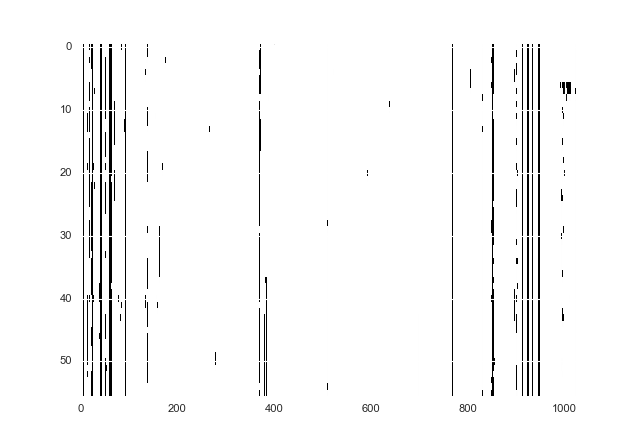

In [95]:
flags = capo.xrfi.omni_chisq_to_flags(m2['chisq'])
plt.figure()
plt.imshow(flags, aspect='auto', interpolation='none')

## Apply Omnicalibrator

In [96]:
ia = InterferometricArrayFromAA(aa, xants=xants)#[22,81])
ia.CalculateUBLs()
cal = OmniCalibrator(ia,verbose=False)

g0 = {'x': {ant: np.ones((nint,nchan),dtype=complex) for ant in ia.antNames}}
v0 = {'xx': {ublGroup[0]: np.ones((nint,nchan),dtype=complex) for ublGroup in ia.ublGroups}}
gSol, vSol = cal.Omnical(fcData, g0, v0, chans = range(180,760), times = [0])

With 18 antennas there are 30 unique baselines.


<IPython.core.display.Javascript object>


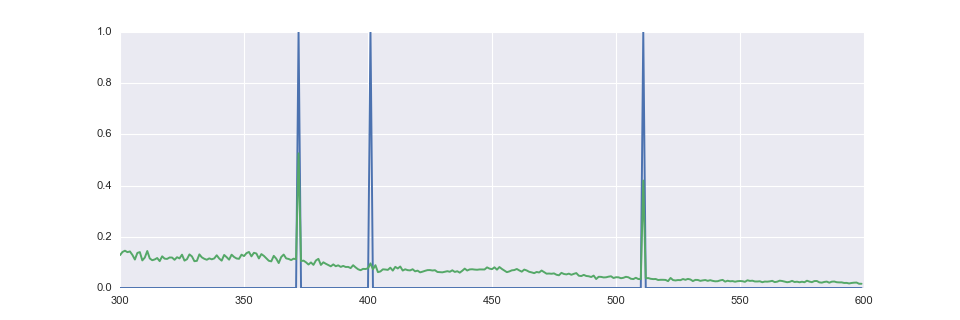

<IPython.core.display.Javascript object>


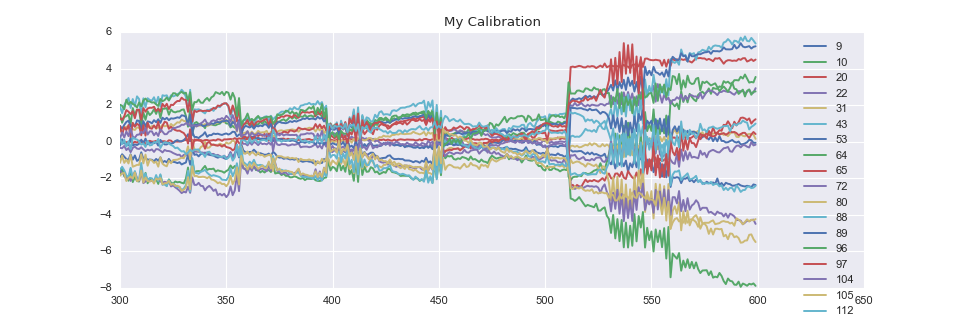

<IPython.core.display.Javascript object>


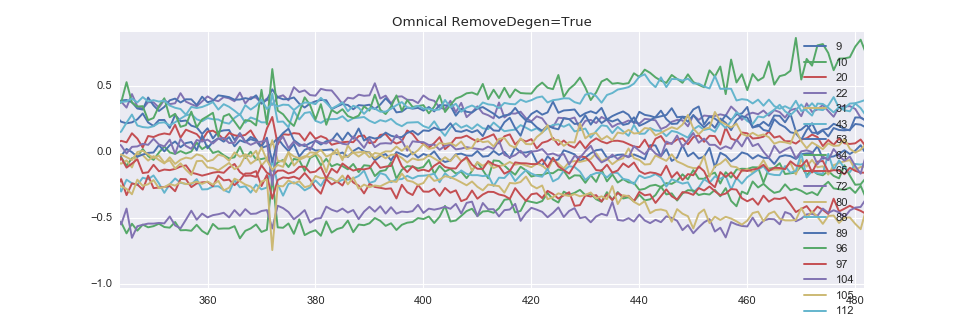

In [99]:
# plt.figure()
# plt.plot(np.unwrap(np.angle(vSol['xx'][cal.ublIndex2VisKey[0]][0][300:600])))
# plt.plot(np.unwrap(np.angle(vSol['xx'][cal.ublIndex2VisKey[1]][0][300:600])))
# plt.plot(np.unwrap(np.angle(vSol['xx'][cal.ublIndex2VisKey[2]][0][300:600])))
# plt.legend([cal.ublIndex2VisKey[n] for n in range(3)], loc=0)

plt.figure(figsize=(12,4))
plt.plot(range(300,600),flags[0,300:600])
plt.plot(range(300,600),m2['chisq'][0,300:600])

plt.figure(figsize=(12,4))
for antName in cal.a.antNames:
    plt.plot(range(300,600), np.unwrap(np.angle(gSol['x'][antName][0][300:600])), label=antName)
plt.xlim([300,650]);# plt.ylim([-2,2])
plt.title('My Calibration')
plt.legend(loc=0)

plt.figure(figsize=(12,4))
for antName in cal.a.antNames:
    plt.plot(range(300,600), np.unwrap(np.angle(g2['x'][antName][0][300:600])), label=antName)
plt.xlim([300,650]);# plt.ylim([-2,2])
plt.title('Omnical RemoveDegen=True')
plt.legend(loc=0)


#print g0['x'][9][0][290:310]
#print gSol['x'][9][0][290:310]

# Simulation

In [98]:
# #SETTINGS
# np.random.seed(6)
# noiseLevel = 0.0
# gainLevel = .4 #exponential amplitude std
# delayErrorLevel = 10.150 #in ns
# nchan = 20
# separation = 14.7
# hexNum = 3
# verbose = False

# #Create array and channel independent quantities
# ha = HexagonalArray(separation, hexNum, verbose=False)
# ha.CalculateUBLs()
# freqs = .1 + .1*np.arange(nchan)/nchan #in GHz
# delayErrors = delayErrorLevel*np.random.randn(ha.nant) #in ns
# gainAmplitudes = np.exp(gainLevel*np.random.randn(ha.nant))
# overallVis = 1.0*(np.random.randn(ha.nubl) + 1.0j*np.random.randn(ha.nubl))


# #overallVis = 0*overallVis +  1*np.exp(1.0j * ha.ublVectors.dot([0, 1.8, 0]))


# #Create observation
# allGains, allTrueVis, allObsVis = [], [], []
# allGuessGains, allGuessVis = [], []
# for chan in range(nchan):
#     #Gains
#     gains = gainAmplitudes * np.exp(2.0j*np.pi*delayErrors*(freqs[chan]))
#     guessGains = np.ones_like(gains)
#     allGains.append(gains); allGuessGains.append(guessGains)
    
#     #Visibilities
#     trueVis = overallVis.copy()
#     guessVis = np.ones_like(trueVis) 
#     #guessVis = overallVis.copy()
#     allTrueVis.append(trueVis); allGuessVis.append(guessVis)
    
#     #Simulate Observations
#     noiselessVis = np.array([gains[ant1] * np.conj(gains[ant2]) * trueVis[ha.indices2ublIndex[(ant1,ant2)]] for (ant1,ant2) in ha.blIndexPairs])
#     noise = noiseLevel*(np.random.randn(ha.nbl) + 1.0j*np.random.randn(ha.nbl))
#     obsVis = np.array(noiselessVis) + noise
#     allObsVis.append(obsVis)
    
# cal = OmniCalibrator(ha, verbose=verbose)

# allGainSols, allVisSols, allGainSols2, allVisSols2  = [], [], [], []
# trueDegens, inputDegens, outputDegens, outputDegens2 = [np.zeros((nchan,4)) for i in range(4)]

# for chan in tqdm(range(nchan)):
#     obsVis, guessGains, guessVis = allObsVis[chan], allGuessGains[chan], allGuessVis[chan]
    
#     if chan==0: gainStart, visStart = cal.PerformLogcal(obsVis, guessGains, guessVis)        
#     else: gainStart, visStart = allGainSols[chan-1], allVisSols[chan-1]
#     gainSols, visSols = cal.PerformLincal(obsVis, gainStart, visStart, guessGains, guessVis, realImagMode=True, maxIter=100)
    
#     if chan==0: gainStart, visStart = cal.PerformLogcal(obsVis, guessGains, guessVis)
#     else: gainStart, visStart = allGainSols2[chan-1], allVisSols2[chan-1]
#     gainSols2, visSols2 = cal.PerformLincal(obsVis, gainStart, visStart, guessGains, guessVis, realImagMode=False, maxIter=100)

#     allGainSols.append(gainSols); allVisSols.append(visSols)
#     allGainSols2.append(gainSols2); allVisSols2.append(visSols2)
    
# allGainSols, allVisSols = cal.OverallBandpassDegeneracyProjection(allGainSols, allVisSols, allGuessGains, allGuessVis)
# allGainSols2, allVisSols2 = cal.OverallBandpassDegeneracyProjection(allGainSols2, allVisSols2, allGuessGains, allGuessVis)

# print np.mean(np.abs(cal.ComputeErrors(obsVis, gainSols, visSols))**2)